<a href="https://colab.research.google.com/github/alexander-toschev/ai-tools/blob/main/3dReconstruction/1_BaseSfm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

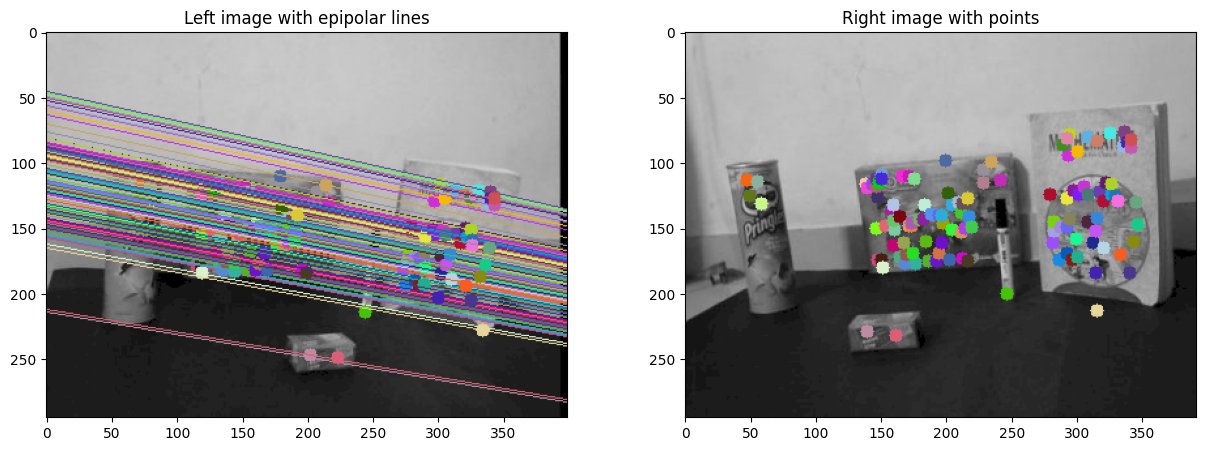

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Загрузка изображений
img1 = cv2.imread('Left.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('Right.png', cv2.IMREAD_GRAYSCALE)

# Детектирование и описание ключевых точек
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Поиск соответствий
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Применяем ratio test
good = []
pts1 = []
pts2 = []

for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

# Находим фундаментальную матрицу
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Отбираем только inlier-ы
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

def draw_epipolar_lines(img1, img2, lines, pts1, pts2):
    '''Рисует эпиполярные линии на img1 и соответствия на img2'''
    img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [img1.shape[1], -(r[2] + r[0] * img1.shape[1]) / r[1]])
        img1_color = cv2.line(img1_color, (x0, y0), (x1, y1), color, 1)
        img1_color = cv2.circle(img1_color, tuple(pt1), 5, color, -1)
        img2_color = cv2.circle(img2_color, tuple(pt2), 5, color, -1)
    return img1_color, img2_color

# Эпиполярные линии для точек на правом изображении (рисуем на левом)
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = draw_epipolar_lines(img1, img2, lines1, pts1, pts2)

# Отображение
plt.figure(figsize=(15, 5))
plt.subplot(121), plt.imshow(img5), plt.title('Left image with epipolar lines')
plt.subplot(122), plt.imshow(img6), plt.title('Right image with points')
plt.show()


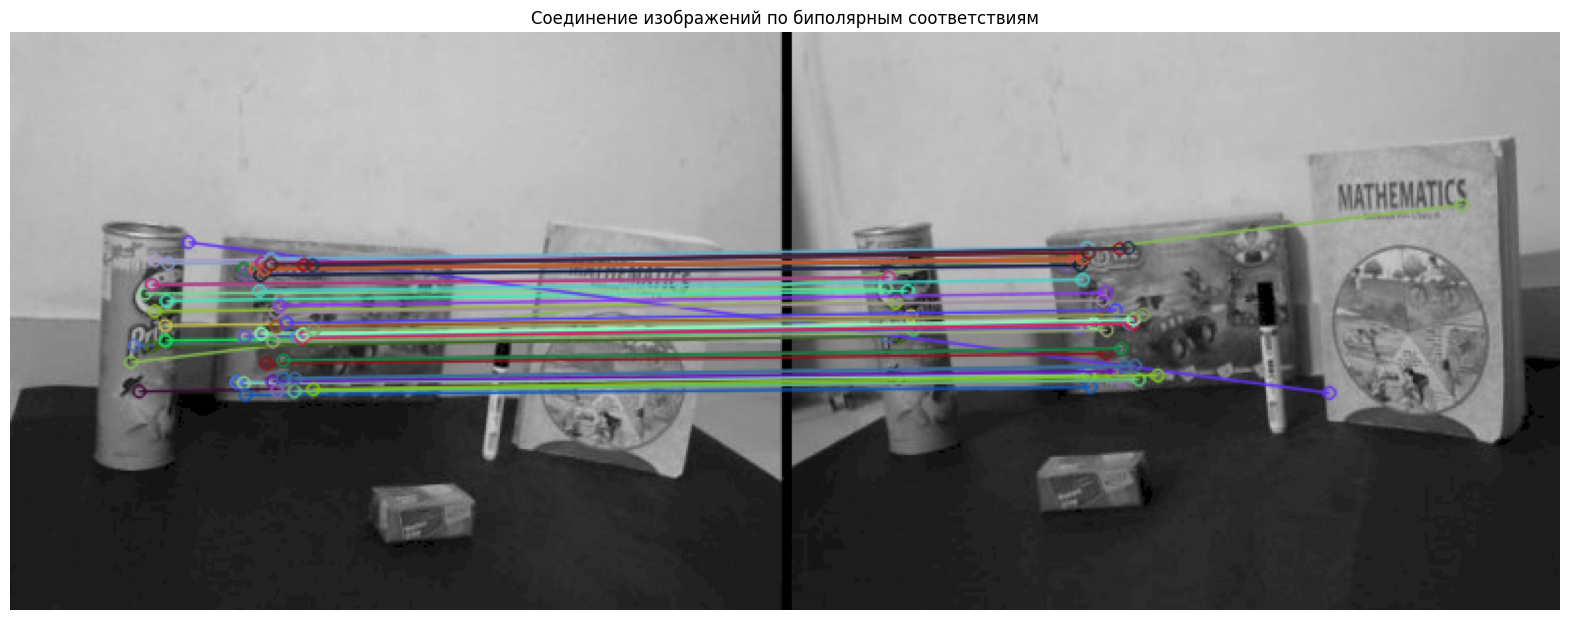

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Загрузка изображений
img1 = cv2.imread('Left.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('Right.png', cv2.IMREAD_GRAYSCALE)


# SIFT: извлечение ключевых точек
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# FLANN matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Ratio test (по Дэвиду Лоу)
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)

# Рисуем 50 лучших совпадений
matched_img = cv2.drawMatches(img1, kp1, img2, kp2, good[:50], None,
                               flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Отображение
plt.figure(figsize=(20, 10))
plt.imshow(matched_img)
plt.title("Соединение изображений по биполярным соответствиям")
plt.axis('off')
plt.show()


115640
115640


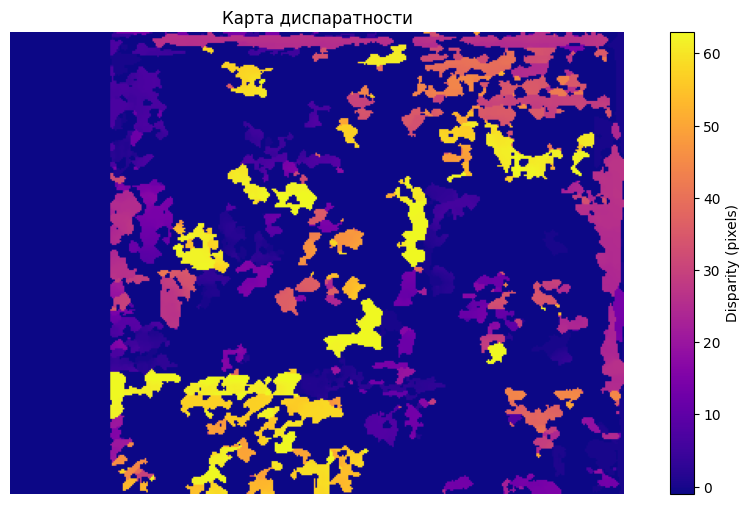

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Загрузка изображений
imgL = cv2.imread('Left.png', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('Right.png', cv2.IMREAD_GRAYSCALE)

# Настройка стерео-мэтчера
window_size = 5
min_disp = 0
num_disp = 64  # должно быть кратно 16
stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=7,
    P1=8 * 3 * window_size ** 2,
    P2=32 * 3 * window_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
)
print(imgL.size)
print(imgR.size)
# Расчет диспаратности
disparity = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

# Отображение
plt.figure(figsize=(12, 6))
plt.imshow(disparity, cmap='plasma')
plt.colorbar(label='Disparity (pixels)')
plt.title('Карта диспаратности')
plt.axis('off')
plt.show()




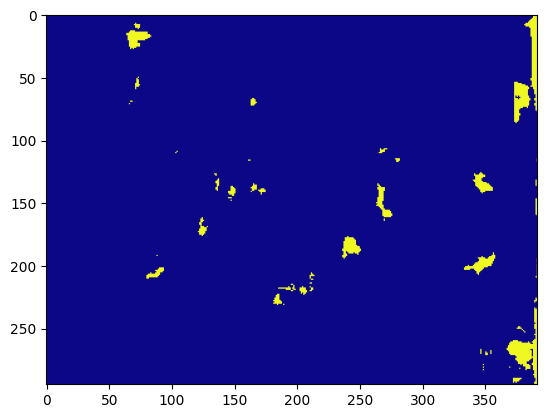

In [12]:
depth = (100 * 10) / (disparity + 1e-6)
plt.imshow(depth, cmap='plasma')

In [ ]:
cv2.SIFT_create()
cv2.BFMatcher()

F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
E = K.T @ F @ K  # если известны intrinsics

_, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)


proj1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
proj2 = K @ np.hstack((R, t))

points_4d = cv2.triangulatePoints(proj1, proj2, pts1.T, pts2.T)
points_3d = points_4d[:3] / points_4d[3]  # нормализуем

[[ 47.873962 155.0013  ]
 [ 47.581932 130.75212 ]
 [ 47.581932 130.75212 ]
 [ 49.08124  125.04282 ]
 [ 52.621338 137.93394 ]
 [ 47.454624 113.77204 ]
 [ 60.160564 144.64926 ]
 [ 58.614334 131.93732 ]
 [ 55.00339  114.169266]
 [147.49986  174.62149 ]
 [138.24371  116.55562 ]
 [138.24371  116.55562 ]
 [150.9805   174.90782 ]
 [146.11443  150.79056 ]
 [139.91756  119.345184]
 [138.51888  113.43951 ]
 [143.9037   116.22464 ]
 [147.84874  126.16324 ]
 [147.84874  126.16324 ]
 [146.59392  118.834755]
 [153.6809   148.58997 ]
 [146.3855   112.51505 ]
 [148.01901  115.39979 ]
 [148.01901  115.39979 ]
 [148.01901  115.39979 ]
 [159.80797  163.82005 ]
 [150.11285  109.8064  ]
 [150.85088  112.64014 ]
 [160.15982  151.92755 ]
 [164.73778  172.76208 ]
 [158.14017  136.74493 ]
 [159.70056  144.17897 ]
 [168.2678   177.6845  ]
 [169.45847  170.6535  ]
 [167.49297  161.22476 ]
 [167.49297  161.22476 ]
 [164.75279  141.6632  ]
 [168.42522  146.31105 ]
 [176.70859  177.10037 ]
 [174.60791  169.91074 ]


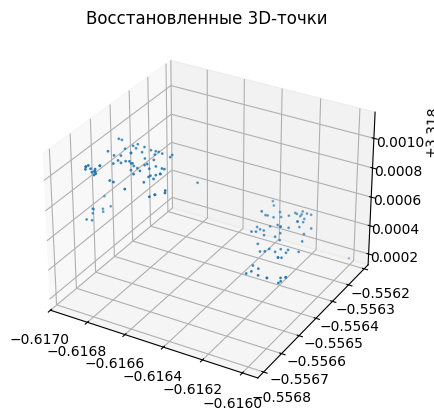

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Загрузка изображений
img1 = cv2.imread('Left.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('Right.png', cv2.IMREAD_GRAYSCALE)

# Обнаружение и описание ключевых точек с помощью SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Сопоставление дескрипторов с использованием FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict()
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Применение теста Лоу для фильтрации хороших совпадений
good_matches = []
pts1 = []
pts2 = []

for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.float32(pts1)
pts2 = np.float32(pts2)

# Вычисление фундаментальной матрицы
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Выбор только инлайеров
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# Предположим, что камеры откалиброваны и известна матрица внутренних параметров K
# Здесь используется примерная матрица K; замените на вашу при наличии
K = np.array([[1000, 0, img1.shape[1] / 2],
              [0, 1000, img1.shape[0] / 2],
              [0, 0, 1]])

# Вычисление эссенциальной матрицы
E = K.T @ F @ K

# Восстановление относительного положения камер
_, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)

# Построение проекционных матриц
P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = K @ np.hstack((R, t))
print(pts2)

# Триангуляция точек
pts1_hom = cv2.undistortPoints(np.expand_dims(pts1, axis=1), K, None)
pts2_hom = cv2.undistortPoints(np.expand_dims(pts2, axis=1), K, None)
points_4d_hom = cv2.triangulatePoints(P1, P2, pts1_hom, pts2_hom)
points_3d = points_4d_hom / points_4d_hom[3]

# Визуализация 3D-точек
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[0], points_3d[1], points_3d[2], s=1)
ax.set_title('Восстановленные 3D-точки')
plt.show()
